### Electricity Auctions
J M Applegate  
##### CAS543 Complexity Economics

This notebook presents a model of electricity market auctions as presented in your Market Structures lecture.  
$n$ generating companies (GenCo) providing electricity to a regional transmission operator (RTO) for $N$ MWhs in 24hrs.  
(Known as the *day ahead* market.  
Assume MWh price decreases linearly with plant capacity, which is modeled as $c = -6*p + 1000$.   
Futher assume that plants are flexible and don't operate when not used, thus not incuring costs. (Crazy, I know, but bear with me.)


In [1]:
# import packages
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
plt.rc('font',**{'family':'sans-serif','sans-serif':['Futura']})
rng = np.random.default_rng() # set up random number generator 

In [2]:
# define functions
def find_capacities(prices, m, b):
    return m * prices + b

def create_expectations(n, capacities, costs):
    capacity_expectations = np.round(capacities, -2)
    cost_expectations = np.empty([n, n])
    expected_rankings = np.empty([n, n], int)  
    for g in range(n):
        cost_expectations[g] = (1 + errors[g]) * costs
        expected_rankings[g] = np.argsort(cost_expectations[g])
    return(capacity_expectations, cost_expectations, expected_rankings)

def generate_bids(n, N, mechanism, capacity_expectations, cost_expectations, expected_rankings, padding, costs):
    bids = np.empty(n)
    for g in range(n):    
        buffer = 0
        winners = []
        first_loser = None
        for r in expected_rankings[g]:
            if buffer < N:
                buffer += capacity_expectations[r]
                winners.append(r)
            else:
                first_loser = r
                break
        last_winner = winners[-1]
        if mechanism == 'uniform':
            if not first_loser:
                bids[g] = price_cap
            elif g == last_winner:
                bids[g] = max(costs[g], cost_expectations[g, first_loser] * padding[g])
            else:
                bids[g] = costs[g]
        elif mechanism == 'discriminatory':
            if not first_loser:
                bids[g] = price_cap
            elif g in winners:
                bids[g] = max(costs[g], cost_expectations[g, first_loser] * padding[g])
            else:
                bids[g] = costs[g]
        else:
            bids[g] = costs[g]
    return(bids)
    
def auction(N, bids, capacities):
    request = N
    quantities = np.zeros(n)
    bid_ranking = np.argsort(bids)
    for i in bid_ranking:
        if request > 0:
            q = capacities[i]
            if q < request:
                request -= q
                quantities[i] = q
            else: 
                quantities[i] = request
                request = 0 
                last_price = bids[i]
    return(quantities, last_price)

def outcomes(mechanism, last_price, bids, quantities, costs):
    if mechanism == 'uniform':
        revenues = last_price * quantities  
    else:
        revenues = bids * quantities
    profits = revenues - costs * quantities
    return(revenues, profits)

In [3]:
# set parameters
n = 5
m = -5
b = 1000
steps = 1000
min_cost = 20
max_cost = 200
min_error = 1
max_error = 20
min_padding = 50
max_padding = 99
cap_multiplier = 1.2

In [41]:
# prices are randomly assingned to GenCos, then capacities are derives from linear price-capacity relationship.
costs = rng.uniform(min_cost, max_cost, n)
capacities = find_capacities(costs, m, b)

# there is a highest price allowed for bidding, found by multiplying highest cost by cap_multiplier
price_cap = max(costs) * cap_multiplier

# expectations are critical in agent based modeling
# capacity expectations are common to all GenCos and found by rounding actual GenCo capacities to nearest 100.
# each GenCo has expectations of the pricing for each other found by multiplying true cost by an error factor.
# error factors are randomly generated between min_error and max_error
# padding is how close a GenCo is willing to bid to the its expected price of another.
# padding factor is randomly assigned to each GenCo using min_padding and max_padding.
# these expectations don't change over the course of the simulations, 
# as the auction mechanism does not reveal any meaningful information.
errors = (rng.uniform(min_error, max_error, n*n) / 100 * np.random.choice([-1,1],size=n*n)).reshape([n,n])
padding = rng.uniform(min_padding, max_padding, n) / 100
#errors = np.zeros([n,n])
#padding = [.99] * n
capacity_expectations, cost_expectations, expected_rankings = create_expectations(n, capacities, costs)

In [59]:
# set desired mechanism by commenting and uncommenting the following three statements.
mechanism = 'uniform'
#mechanism = 'discriminatory'
#mechanism = 'ownbid'

# initialise arrays to store simulation results for each time step.
RTO_costs = np.empty(steps)
GenCo_profits = np.empty([steps,n])

# for timesteps specified by steps, run a series of auctions. 
# each time step the RTO request varies.
for s in range(steps): 
    N = rng.uniform(int(np.mean(capacities)), int(np.sum(capacities)))
    bids = generate_bids(n, N, mechanism, capacity_expectations, cost_expectations, expected_rankings, padding, costs)
    quantities, last_price = auction(N, bids, capacities)
    revenues, profits = outcomes(mechanism, last_price, bids, quantities, costs)
    RTO_costs[s] = sum(revenues)
    GenCo_profits[s] = profits

In [53]:
# print cost and profit results from last simulation
print(round(np.mean(RTO_costs)))
round(np.mean(np.sum(GenCo_profits, axis = 1)))

134100


42633

In [60]:
# save cost and profit results to named arrays for later comparison
# RTO_costs_uniform = RTO_costs
# GenCo_profits_uniform = GenCo_profits
# RTO_costs_discriminatory = RTO_costs
# GenCo_profits_discriminatory = GenCo_profits
# RTO_costs_ownbid = RTO_costs
# GenCo_profits_ownbid = GenCo_profits

In [56]:
# calculate statistics for costs and profits
mean_cost_uniform = np.mean(RTO_costs_uniform)
mean_profit_uniform = np.mean(np.sum(GenCo_profits_uniform, axis = 1))
mean_cost_discriminatory = np.mean(RTO_costs_discriminatory)
mean_profit_discriminatory = np.mean(np.sum(GenCo_profits_discriminatory, axis = 1))

In [57]:
print('mean profits for discriminatory pricing:', round(mean_profit_discriminatory))
print('mean profits for uniform pricing:', round(mean_profit_uniform))
print('mean costs for discriminatory pricing:', round(mean_cost_discriminatory))
print('mean costs for uniform pricing:', round(mean_cost_uniform))

mean profits for discriminatory pricing: 42633
mean profits for uniform pricing: 80766
mean costs for discriminatory pricing: 134100
mean costs for uniform pricing: 177694


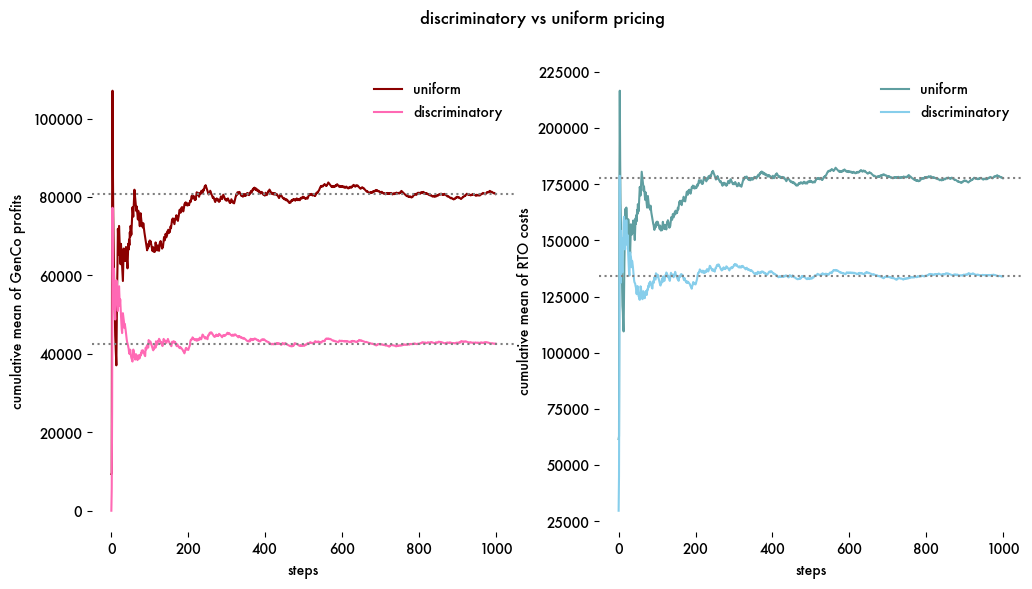

In [64]:
# plot profit and cost values for the various auction price mechanisms
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 6))

ax[0].plot(range(steps), np.cumsum(np.sum(GenCo_profits_uniform, axis=1)) / np.arange(1, steps + 1), c = 'darkred', label = 'uniform')
ax[0].plot(np.cumsum(np.sum(GenCo_profits_discriminatory, axis=1)) / np.arange(1, steps + 1), c = 'hotpink', label = 'discriminatory')
ax[0].set_xlabel('steps')
ax[0].set_ylabel('cumulative mean of GenCo profits')
ax[0].legend(frameon = False)
ax[1].plot(range(steps), np.cumsum(RTO_costs_uniform) / np.arange(1, steps + 1), c = 'cadetblue', label = 'uniform')
ax[1].plot(np.cumsum(RTO_costs_discriminatory) / np.arange(1, steps + 1), c = 'skyblue', label = 'discriminatory')
ax[1].set_xlabel('steps')
ax[1].set_ylabel('cumulative mean of RTO costs')
ax[1].legend(frameon = False)

#ax[0].annotate('uniform', xy=(600, 63000))
#ax[0].annotate('discriminatory', xy=(600, 50500))
#ax[1].annotate('uniform', xy=(700, 160000))
#ax[1].annotate('discriminatory', xy=(700, 148000))
ax[1].axhline(y = mean_cost_uniform, linestyle = 'dotted', c = 'grey')
ax[1].axhline(y = mean_cost_discriminatory, linestyle = 'dotted', c = 'grey')
ax[0].axhline(y = mean_profit_uniform, linestyle = 'dotted', c = 'grey')
ax[0].axhline(y = mean_profit_discriminatory, linestyle = 'dotted', c = 'grey')

fig.suptitle('discriminatory vs uniform pricing')
sns.despine(left = True, bottom = True)